In [1]:
import pandas as pd
import numpy as np
import os,sys
import glob
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import random
from collections import Counter, defaultdict
from tqdm import tqdm

In [87]:
import sklearn
from sklearn.base import clone
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
import sklearn.metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

In [139]:
path = os.getcwd()
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2014*","*csv"))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2015*","*csv")))
files.extend(glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2016*","*csv")))

In [140]:
train = pd.DataFrame()
for f in files:
    try:
        if train.empty:
            train = pd.read_csv(f)
        else:
            train = pd.concat([train,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20140101-20141231\beijing_all_20141231.csv. Message is: Error tokenizing data. C error: Expected 3 fields in line 34, saw 5

Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_all_20161231.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161230.csv. Message is: No columns to parse from file
Error reading C:\Users\Yao\Radix_assignment\takehome\takehome\data\beijing_20160101-20161231\beijing_extra_20161231.csv. Message is: No columns to parse from file


In [141]:
files = glob.glob(os.path.join(path,"takehome","takehome","data","beijing_2017*","*csv"))
test = pd.DataFrame()
for f in files:
    try:
        if test.empty:
            test = pd.read_csv(f)
        else:
            test = pd.concat([test,pd.read_csv(f)])
    except Exception as e:
        print (f"Error reading {f}. Message is: {e}")

In [142]:
def preprocess(df):
    df['Datetime'] = pd.to_datetime(df['date'],format='%Y%m%d')+pd.to_timedelta(df['hour'].astype(int), unit='H')
    df = df.set_index('Datetime')
    df = df.drop(columns=['date','hour'])
    #Question: Do we need to remove all pollutants with suffix '_24h'?
    pollutant = set(df.type)
    pollutant.remove('AQI')
    pollutant = [p for p in pollutant if '24h' not in p]
    df = df.loc[df['type'].isin(pollutant)]
    return df

In [143]:
train = preprocess(train)
test = preprocess(test)

In [144]:
test

,type,东四,天坛,官园,万寿西宫,奥体中心,农展馆,万柳,北部新区,植物园,...,密云水库,东高村,永乐店,榆垡,琉璃河,前门,永定门内,西直门北,南三环,东四环
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 22:00:00,PM2.5,469.0,357.0,476.0,416.0,453.0,398.0,468.0,479.0,458.0,...,380.0,377.0,329.0,285.0,376.0,436.0,415.0,514.0,431.0,390.0
2017-01-01 22:00:00,PM10,594.0,449.0,548.0,474.0,467.0,469.0,518.0,487.0,490.0,...,NaN,NaN,NaN,322.0,447.0,NaN,NaN,NaN,467.0,394.0
2017-01-01 23:00:00,PM2.5,470.0,351.0,500.0,403.0,417.0,392.0,459.0,481.0,442.0,...,329.0,387.0,317.0,302.0,369.0,443.0,409.0,508.0,426.0,390.0
2017-01-01 23:00:00,PM10,558.0,467.0,583.0,469.0,443.0,480.0,529.0,497.0,497.0,...,NaN,NaN,NaN,319.0,407.0,NaN,NaN,NaN,444.0,NaN
2017-01-02 00:00:00,PM2.5,458.0,346.0,500.0,389.0,395.0,381.0,441.0,488.0,441.0,...,276.0,351.0,326.0,302.0,361.0,429.0,401.0,497.0,420.0,374.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-29 22:00:00,CO,0.5,0.3,0.4,0.5,0.4,0.5,0.5,0.7,0.5,...,0.3,0.2,0.4,0.5,0.3,0.6,0.4,0.8,0.5,0.5
2017-04-29 23:00:00,SO2,12.0,7.0,9.0,9.0,9.0,13.0,7.0,3.0,2.0,...,8.0,7.0,20.0,11.0,16.0,13.0,17.0,20.0,24.0,13.0
2017-04-29 23:00:00,NO2,44.0,45.0,55.0,46.0,59.0,46.0,95.0,64.0,10.0,...,13.0,20.0,30.0,19.0,35.0,133.0,95.0,143.0,101.0,75.0


In [179]:
test_new = pd.concat([train.iloc[train.index>'2016-12-01'],test])

In [223]:
# pd.melt(df)

In [224]:
# #build a model for '万柳' first
# subset = df.loc[:,['type','万柳']]
# subset.sort_values(by = ['Datetime'])
# subset = subset.pivot_table(values='万柳', index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

In [225]:
# subset['location'] = '万柳'

In [226]:
def stratified_group_k_fold(X, y, groups, k, seed=None):
    labels_num = np.max(y) + 1
    y_counts_per_group = defaultdict(lambda: np.zeros(labels_num))
    y_distr = Counter()
    for label, g in zip(y, groups):
        y_counts_per_group[g][label] += 1
        y_distr[label] += 1

    y_counts_per_fold = defaultdict(lambda: np.zeros(labels_num))
    groups_per_fold = defaultdict(set)

    def eval_y_counts_per_fold(y_counts, fold):
        y_counts_per_fold[fold] += y_counts
        std_per_label = []
        for label in range(labels_num):
            label_std = np.std([y_counts_per_fold[i][label] / y_distr[label] for i in range(k)])
            std_per_label.append(label_std)
        y_counts_per_fold[fold] -= y_counts
        return np.mean(std_per_label)
    
    groups_and_y_counts = list(y_counts_per_group.items())
    random.Random(seed).shuffle(groups_and_y_counts)

    for g, y_counts in tqdm(sorted(groups_and_y_counts, key=lambda x: -np.std(x[1])), total=len(groups_and_y_counts)):
        best_fold = None
        min_eval = None
        for i in range(k):
            fold_eval = eval_y_counts_per_fold(y_counts, i)
            if min_eval is None or fold_eval < min_eval:
                min_eval = fold_eval
                best_fold = i
        y_counts_per_fold[best_fold] += y_counts
        groups_per_fold[best_fold].add(g)

    all_groups = set(groups)
    for i in range(k):
        train_groups = all_groups - groups_per_fold[i]
        test_groups = groups_per_fold[i]

        train_indices = [i for i, g in enumerate(groups) if g in train_groups]
        test_indices = [i for i, g in enumerate(groups) if g in test_groups]

        yield train_indices, test_indices

In [56]:
from sklearn.model_selection import StratifiedKFold

In [257]:
def process_one_location(df, location, take_log=True, n_lag=3):
    #build a model for '万柳' first
    subset = df.loc[:,['type',location]]
    subset.sort_values(by = ['Datetime'])
    subset = subset.pivot_table(values=location, index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')
#     subset['location'] = location
    
    #filling missing hours
    subset_augmented = subset.asfreq('h')
    subset_augmented = subset_augmented.interpolate(method = 'linear')
    #before April 2014, there is no extra data. Therefore we only use data after that time
    subset_augmented = subset_augmented.dropna()
    
    if take_log:
        subset_augmented = subset_augmented.apply(lambda x: np.log(x))
        
    subset_augmented = feature_engineering(subset_augmented,n_lag)
    
    subset_augmented =  subset_augmented.dropna()
    subset_augmented['location'] = location
    true_y =  subset_augmented[["PM2.5",'location']]
    subset_augmented['target'] = subset_augmented['PM2.5_diff']
    
    subset_augmented = subset_augmented.drop(columns=['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff','PM2.5','PM10','SO2','CO','NO2','O3'])
    
    return subset_augmented, true_y
    
def feature_engineering(subset_augmented, n_lag):
    
    subset_augmented["PM2.5_diff"] = subset_augmented["PM2.5"]-subset_augmented["PM2.5"].shift(1)
    subset_augmented["PM10_diff"] = subset_augmented["PM10"]-subset_augmented["PM10"].shift(1)
    subset_augmented["SO2_diff"] = subset_augmented["SO2"]-subset_augmented["SO2"].shift(1)
    subset_augmented["CO_diff"] = subset_augmented["CO"]-subset_augmented["CO"].shift(24)
    subset_augmented["NO2_diff"] = subset_augmented["NO2"]-subset_augmented["NO2"].shift(24)
    subset_augmented["O3_diff"] = subset_augmented["O3"]-subset_augmented["O3"].shift(24)
    
    subset_augmented = create_lag(n_lag,subset_augmented)
    
    subset_augmented = calculate_rolling_stat(subset_augmented)
    
    return subset_augmented
        
def create_lag(n_lag, subset_augmented):
    col = ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']
    for lag in range(1,n_lag+1):
        tmp = subset_augmented[col].shift(lag)
        tmp.columns=[f'{c}_lag_{lag}' for c in col]
        subset_augmented = pd.concat([subset_augmented,tmp],axis=1)
        
    return subset_augmented

def calculate_rolling_stat(res):
    for p in ['PM2.5_diff','PM10_diff','SO2_diff','CO_diff','NO2_diff','O3_diff']:
        res[f'{p}_daily_mean'] = res[p].rolling(24).mean()
        res[f'{p}_daily_median'] = res[p].rolling(24).median()
        res[f'{p}_daily_std'] = res[p].rolling(24).std()
        res[f'{p}_weekly_mean'] = res[p].rolling(24*7).mean()
        res[f'{p}_weekly_median'] = res[p].rolling(24*7).median()
        res[f'{p}_weekly_std'] = res[p].rolling(24*7).std()
        res[f'{p}_monthly_mean'] = res[p].rolling(24*30).mean()
        res[f'{p}_monthly_median'] = res[p].rolling(24*30).median()
        res[f'{p}_monthly_std'] = res[p].rolling(24*30).std()
    return res

In [289]:
alldata = pd.DataFrame()
allTarget = pd.DataFrame()
for l in train.columns[1:]:
    subset,true_y = process_one_location(train,l)
    alldata = pd.concat([alldata,subset])
    allTarget = pd.concat([allTarget,true_y])

In [290]:
allTestdata = pd.DataFrame()
allTestTarget = pd.DataFrame()
for l in test_new.columns[1:]:
    subset,true_y = process_one_location(test_new,l)
    allTestdata = pd.concat([allTestdata,subset])
    allTestTarget = pd.concat([allTestTarget,true_y])

In [291]:
alldata_noTS = alldata.reset_index(drop=True)
allTarget_noTS = allTarget.reset_index(drop=True)

alldata_noTS['location'] = alldata_noTS['location'].astype('category')
encode_mapping = dict( enumerate(alldata_noTS['location'].cat.categories ) )
alldata_noTS['location'] = alldata_noTS['location'].cat.codes
allTestdata['location'] = allTestdata['location'].astype('category')
allTestdata['location'] = allTestdata['location'].cat.codes

In [293]:
allTestdata

,PM2.5_diff_lag_1,PM10_diff_lag_1,SO2_diff_lag_1,CO_diff_lag_1,NO2_diff_lag_1,O3_diff_lag_1,PM2.5_diff_lag_2,PM10_diff_lag_2,SO2_diff_lag_2,CO_diff_lag_2,...,O3_diff_daily_median,O3_diff_daily_std,O3_diff_weekly_mean,O3_diff_weekly_median,O3_diff_weekly_std,O3_diff_monthly_mean,O3_diff_monthly_median,O3_diff_monthly_std,location,target
Datetime,,,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,0.015317,0.015293,0.000000,0.434161,0.299997,-0.601883,0.015556,0.015530,0.000000,0.442291,...,-0.474106,0.070657,0.241612,-0.066241,1.218434,-0.015821,0.0,1.459128,2,0.015086
2017-01-01 01:00:00,0.015086,0.015063,0.000000,0.426329,0.296266,-0.617864,0.015317,0.015293,0.000000,0.434161,...,-0.483849,0.073808,0.237133,-0.073993,1.220273,-0.012852,0.0,1.455682,2,0.014862
2017-01-01 02:00:00,0.014862,0.014839,0.000000,0.418779,0.292627,-0.634746,0.015086,0.015063,0.000000,0.426329,...,-0.494010,0.077183,0.231920,-0.092702,1.222203,-0.009783,0.0,1.451991,2,0.014645
2017-01-01 03:00:00,0.014645,0.014622,0.000000,0.411495,0.289078,-0.652611,0.014862,0.014839,0.000000,0.418779,...,-0.504615,0.080807,0.226027,-0.111572,1.224168,-0.007385,0.0,1.449465,2,0.014433
2017-01-01 04:00:00,0.014433,0.014411,0.000000,0.404464,0.285614,-0.671548,0.014645,0.014622,0.000000,0.411495,...,-0.515697,0.084704,0.219496,-0.130191,1.226130,-0.004257,0.0,1.445542,2,0.014228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-04-29 19:00:00,0.325422,0.293348,0.693147,-0.693147,-0.146603,-0.351844,-0.037740,0.146603,0.000000,-0.693147,...,-0.151783,0.965751,-0.071315,0.020203,0.892079,-0.006747,0.0,1.375586,3,0.494019
2017-04-29 20:00:00,0.494019,0.199129,0.154151,-0.287682,-0.315081,0.064539,0.325422,0.293348,0.693147,-0.693147,...,-0.151783,0.963830,-0.072695,0.020203,0.891435,-0.005277,0.0,1.375267,3,-0.293348
2017-04-29 21:00:00,-0.293348,-0.157629,0.000000,0.287682,0.847298,0.225956,0.494019,0.199129,0.154151,-0.287682,...,-0.151783,0.958711,-0.073995,0.020203,0.890791,-0.002742,0.0,1.374063,3,0.241162


In [294]:
# #build a model for '万柳' first
# subset = df.loc[:,['type','万柳']]
# subset.sort_values(by = ['Datetime'])
# subset = subset.pivot_table(values='万柳', index=[df.index], columns='type').rename_axis(None,axis=1).reset_index().set_index('Datetime')

In [295]:
# #filling missing hours
# subset_augmented = subset.asfreq('h')
# subset_augmented = subset_augmented.interpolate(method = 'linear')
# #before April 2014, there is no extra data. Therefore we only use data after that time
# subset_augmented = subset_augmented.dropna()

In [296]:
# for p in subset_augmented.columns:
#     subset_augmented[f'{p}_log'] = np.log(subset_augmented[p])

In [297]:
# subset_augmented = subset_augmented.apply(lambda x: np.log(x))

In [298]:
# sns.pairplot(subset_augmented)

In [299]:
# sns.pairplot(subset_augmented.diff())

In [300]:
import lightgbm as lgb

In [301]:
seed0=617
# params = {'num_leaves': 555,
#           'min_child_weight': 0.034,
#           'feature_fraction': 0.379,
#           'bagging_fraction': 0.418,
#           'min_data_in_leaf': 106,
#           'objective': 'regression',
#           'max_depth': -1,
#           'learning_rate': 0.005,
#           "boosting_type": "gbdt",
#           "bagging_seed": 42,
#           "metric": 'rmse',
#           "verbosity": -1,
#           'reg_alpha': 0.3899,
#           'reg_lambda': 0.648,
#           'random_state': 617,
#          }
lgb_params = {
            'objective': 'regression',
            'subsample': 0.72,
            'subsample_freq': 5,
            'max_depth': -1,
            'learning_rate': 0.01,
            "boosting_type": "gbdt",
            "metric": 'rmse',
            "verbosity": -1,
            'feature_fraction': 0.5,
            'lambda_l1': 0.5,
            'lambda_l2': 1.0,
            'random_state': seed0,
            'feature_fraction_seed': seed0,
            'bagging_seed': seed0,
         }
# y_preds = np.zeros(test.shape[0])
# y_oof = np.zeros(alldata_noTS.shape[0])

# predicted  = pd.DataFrame()

# feature_importances = pd.DataFrame()
# feature_importances['feature'] = alldata_noTS.columns[:-1]
# mean_score = []

# skf = StratifiedKFold(n_splits=5)

In [302]:
def train_lgb(data,test,label,params,n_splits=5):
    skf = StratifiedKFold(n_splits)
#     predicted  = pd.DataFrame()
    y_oof = np.zeros(data.shape[0])
    
    test_predictions = np.zeros(test.shape[0])

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = data.columns[:-1]
    mean_score = []
    
    for fold_n, (train_index, valid_index) in enumerate(skf.split(data,label)):
        print(f'Fold: {fold_n+1}')
        X_train, X_valid = data.iloc[train_index].loc[:,data.columns!="target"],data.iloc[valid_index].loc[:,data.columns!="target"]
        y_train, y_valid = data.iloc[train_index].loc[:,"target"], data.iloc[valid_index].loc[:,"target"]

        dtrain = lgb.Dataset(X_train, label=y_train, categorical_feature = ['location'])
        dvalid = lgb.Dataset(X_valid, label=y_valid, categorical_feature = ['location'])

        clf = lgb.train(params, dtrain, 10000, valid_sets = [dtrain, dvalid],early_stopping_rounds = 50, verbose_eval=500)

        feature_importances[f'fold_{fold_n + 1}'] = clf.feature_importance()
        y_pred_valid = clf.predict(X_valid,num_iteration=clf.best_iteration)
        y_oof[valid_index] = y_pred_valid
        
        #Predict the test set       
        test_predictions += clf.predict(test.loc[:,data.columns!="target"],num_iteration=clf.best_iteration) / n_splits

#         predicted = pd.concat([predicted,pd.DataFrame(y_pred_valid,index=subset_augmented.index[valid_index], columns=['predicted'])])
    #     print(predicted)

        val_score = np.sqrt(mean_squared_error(y_pred_valid, y_valid))
        print(f'val rmse score is {val_score}')
        mean_score.append(val_score)

        del X_train, X_valid, y_train, y_valid
        gc.collect()

    print(f'mean rmse score over folds is {np.mean(mean_score)}')
    
    return y_oof, feature_importances,test_predictions

In [303]:
n_splits = 5
predicted, feature_importances,test_predictions = train_lgb(alldata_noTS,allTestdata,alldata_noTS['location'],lgb_params, n_splits)

In [153]:
len(predicted)

815578

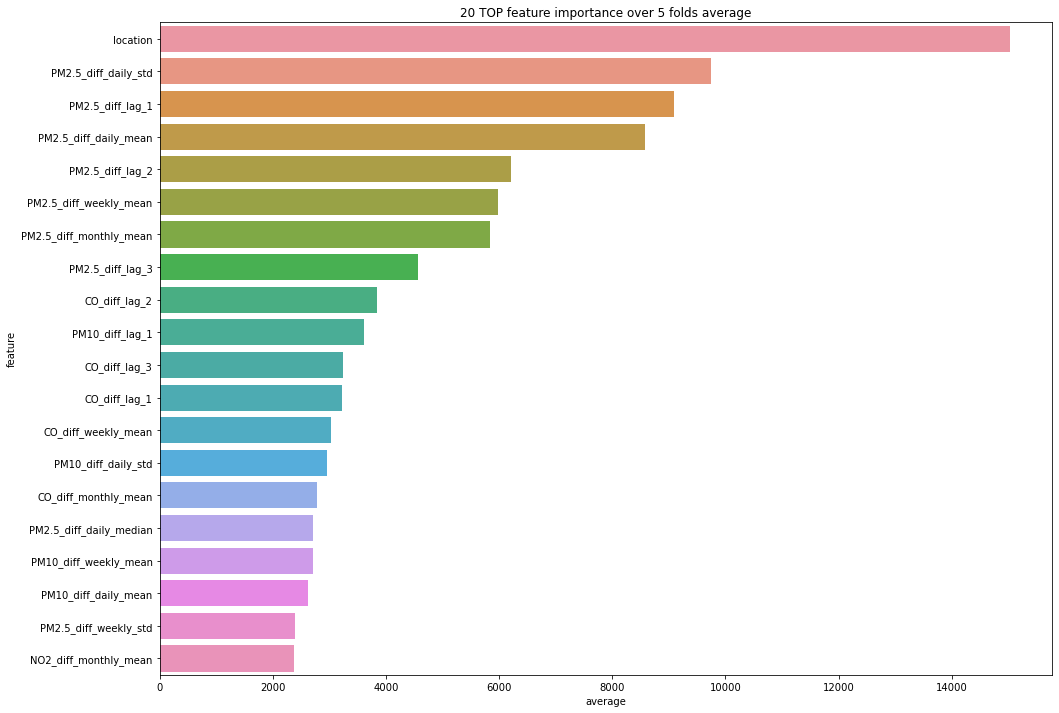

In [305]:
feature_importances['average'] = feature_importances[[f'fold_{fold_n + 1}' for fold_n in range(n_splits)]].mean(axis=1)
# feature_importances.to_csv('feature_importances.csv')

plt.figure(figsize=(16, 12))
sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(20), x='average', y='feature');
plt.title('20 TOP feature importance over {} folds average'.format(n_splits));

In [306]:
allTarget_noTS['predicted'] = predicted

In [307]:
allTarget_noTS

,PM2.5,location,predicted
0,4.062166,东四,0.088755
1,4.051785,东四,0.041585
2,3.914021,东四,0.058353
3,3.895894,东四,0.183705
4,3.039749,东四,0.202676
...,...,...,...
815573,2.708050,东四环,0.096484
815574,2.397895,东四环,0.009670
815575,2.833213,东四环,0.164807
815576,2.564949,东四环,-0.104489


In [308]:
allTarget_noTS["PM2.5_y"] = allTarget_noTS['PM2.5'].shift(1)

allTarget_noTS['prediction'] = allTarget_noTS['predicted'] + allTarget_noTS['PM2.5_y']

allTarget_noTS['prediction']=allTarget_noTS['prediction'].map(lambda x: np.exp(x))
allTarget_noTS['PM2.5_y']=allTarget_noTS['PM2.5_y'].map(lambda x: np.exp(x))
allTarget_noTS['PM2.5']=allTarget_noTS['PM2.5'].map(lambda x: np.exp(x))

allTarget_noTS = allTarget_noTS.dropna()

In [309]:
print(f'light gbm rmse error is {np.sqrt(mean_squared_error(allTarget_noTS["prediction"],allTarget_noTS["PM2.5"]))}')
print(f'Naive model: use last hour to predict next hour {np.sqrt(mean_squared_error(allTarget_noTS["PM2.5_y"],allTarget_noTS["PM2.5"]))}')

light gbm rmse error is 17.773411872376247
Naive model: use last hour to predict next hour 19.536115085851684


In [310]:
allTarget_noTS

,PM2.5,location,predicted,PM2.5_y,prediction
1,57.5,东四,0.041585,58.1,60.567026
2,50.1,东四,0.058353,57.5,60.955103
3,49.2,东四,0.183705,50.1,60.203240
4,20.9,东四,0.202676,49.2,60.254021
5,19.3,东四,0.485325,20.9,33.956291
...,...,...,...,...,...
815573,15.0,东四环,0.096484,11.0,12.114214
815574,11.0,东四环,0.009670,15.0,15.145754
815575,17.0,东四环,0.164807,11.0,12.970823
815576,13.0,东四环,-0.104489,17.0,15.313342


In [311]:
allTarget_noTS.groupby(allTarget_noTS.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5)

location
万寿西宫    16.655444
万柳      15.362227
东四      16.531950
东四环     16.855696
东高村     16.055221
丰台花园    17.951369
云岗      16.062651
亦庄      21.111848
八达岭     11.822561
农展馆     17.220514
前门      26.146426
北部新区    15.343918
南三环     17.268763
古城      16.171680
大兴      19.357573
天坛      14.960173
奥体中心    16.728727
官园      15.082725
定陵      16.163052
密云      14.087198
密云水库    11.339782
平谷      19.287370
延庆      16.287614
怀柔      15.309705
房山      20.871498
昌平      15.579807
植物园     14.526982
榆垡      23.361122
永乐店     23.289021
永定门内    18.658332
琉璃河     25.073106
西直门北    20.546090
通州      18.829612
门头沟     14.336439
顺义      16.861442
dtype: float64

In [312]:
allTarget_noTS.groupby(allTarget_noTS.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['PM2.5_y']) ** .5)

location
万寿西宫    19.281131
万柳      18.126832
东四      18.980841
东四环     19.926190
东高村     17.713358
丰台花园    19.629754
云岗      18.192209
亦庄      21.992032
八达岭     13.393922
农展馆     19.324509
前门      22.409097
北部新区    17.621947
南三环     19.903106
古城      18.629238
大兴      21.934137
天坛      17.798987
奥体中心    19.003183
官园      17.531964
定陵      17.790649
密云      16.076542
密云水库    13.166323
平谷      20.387322
延庆      16.195083
怀柔      16.058972
房山      23.570907
昌平      18.196917
植物园     16.986616
榆垡      26.088686
永乐店     24.211631
永定门内    21.248814
琉璃河     26.237674
西直门北    20.907987
通州      21.565853
门头沟     16.266571
顺义      19.460702
dtype: float64

In [313]:
allTestTarget['predicted'] = test_predictions

In [314]:
allTestTarget

,PM2.5,location,predicted
Datetime,,,
2017-01-01 00:00:00,5.865868,东四,0.005289
2017-01-01 01:00:00,5.880730,东四,0.005636
2017-01-01 02:00:00,5.895375,东四,0.004492
2017-01-01 03:00:00,5.909808,东四,0.005430
2017-01-01 04:00:00,5.924036,东四,0.011226
...,...,...,...
2017-04-29 19:00:00,4.077537,东四环,0.280413
2017-04-29 20:00:00,3.784190,东四环,0.124709
2017-04-29 21:00:00,4.025352,东四环,0.097470


In [315]:
allTestTarget["PM2.5_y"] = allTestTarget['PM2.5'].shift(1)
allTestTarget['prediction'] = allTestTarget['predicted'] + allTestTarget['PM2.5_y']
allTestTarget['prediction']=allTestTarget['prediction'].map(lambda x: np.exp(x))
allTestTarget['PM2.5_y']=allTestTarget['PM2.5_y'].map(lambda x: np.exp(x))
allTestTarget['PM2.5']=allTestTarget['PM2.5'].map(lambda x: np.exp(x))
allTestTarget = allTestTarget.dropna()

In [316]:
allTestTarget

,PM2.5,location,predicted,PM2.5_y,prediction
Datetime,,,,,
2017-01-01 01:00:00,358.070588,东四,0.005636,352.788235,354.782192
2017-01-01 02:00:00,363.352941,东四,0.004492,358.070588,359.682661
2017-01-01 03:00:00,368.635294,东四,0.005430,363.352941,365.331252
2017-01-01 04:00:00,373.917647,东四,0.011226,368.635294,372.796923
2017-01-01 05:00:00,379.200000,东四,0.018707,373.917647,380.978503
...,...,...,...,...,...
2017-04-29 19:00:00,59.000000,东四环,0.280413,36.000000,47.652339
2017-04-29 20:00:00,44.000000,东四环,0.124709,59.000000,66.836290
2017-04-29 21:00:00,56.000000,东四环,0.097470,44.000000,48.504629


In [317]:
print(f'light gbm rmse error is {np.sqrt(mean_squared_error(allTestTarget["prediction"],allTestTarget["PM2.5"]))}')
print(f'Naive model: use last hour to predict next hour {np.sqrt(mean_squared_error(allTestTarget["PM2.5_y"],allTestTarget["PM2.5"]))}')

light gbm rmse error is 18.611680791594814
Naive model: use last hour to predict next hour 21.127541982522718


In [318]:
allTestTarget.groupby(allTestTarget.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['prediction']) ** .5)

location
万寿西宫    22.667231
万柳      15.088652
东四      17.429621
东四环     16.106284
东高村     18.108722
丰台花园    17.021473
云岗      18.980110
亦庄      16.068538
八达岭     11.609241
农展馆     17.232647
前门      20.272297
北部新区    18.153049
南三环     19.097063
古城      18.534855
大兴      17.499584
天坛      15.443663
奥体中心    16.513401
官园      17.397550
定陵      12.516538
密云      15.286278
密云水库    10.776678
平谷      25.333927
延庆      19.412253
怀柔      19.474535
房山      19.806603
昌平      15.996223
植物园     15.212726
榆垡      30.900390
永乐店     19.066282
永定门内    18.982331
琉璃河     23.546696
西直门北    24.533825
通州      17.669419
门头沟     18.510638
顺义      17.487302
dtype: float64

In [319]:
allTestTarget.groupby(allTestTarget.location).apply(
    lambda x: mean_squared_error(x['PM2.5'], x['PM2.5_y']) ** .5)

location
万寿西宫    25.813444
万柳      18.675397
东四      21.022219
东四环     19.407068
东高村     19.857058
丰台花园    19.534238
云岗      21.717022
亦庄      19.282128
八达岭     13.100549
农展馆     19.417847
前门      23.696044
北部新区    19.769840
南三环     24.251081
古城      22.677534
大兴      20.586609
天坛      19.332699
奥体中心    19.824364
官园      19.798922
定陵      15.972925
密云      16.238071
密云水库    12.829635
平谷      24.884171
延庆      21.121923
怀柔      18.746932
房山      22.063296
昌平      19.796046
植物园     17.363153
榆垡      31.277469
永乐店     21.822923
永定门内    23.718545
琉璃河     26.225730
西直门北    25.159040
通州      22.134436
门头沟     21.935316
顺义      19.772691
dtype: float64

<AxesSubplot:xlabel='Datetime'>

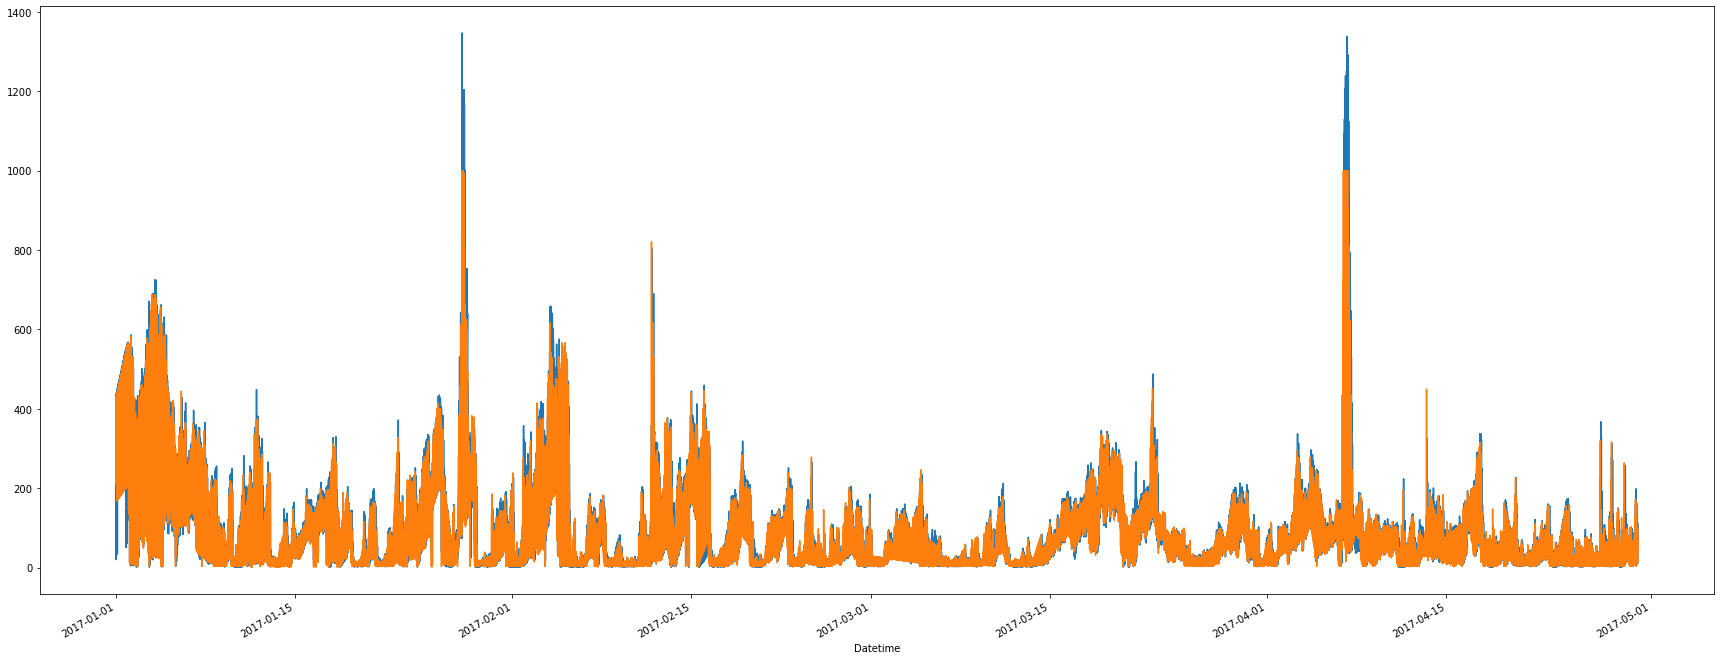

In [221]:
plt.figure(figsize=(30, 12))
allTestTarget['prediction'].plot()
allTestTarget['PM2.5'].plot()